In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

using MuJoCo
using CairoMakie
using LinearAlgebra
using MatrixEquations: ared
using MuJoCo
using JSON
import MuJoCo as MJ
using Rotations  
using Quaternions

  Activating project at `~/16745_Unitree_G1_Goal_Kicking_Julia/src2`


## Initialize Mujoco


In [2]:
init_visualiser()
isplot = true
model = MJ.load_model("../unitree_robots/g1/scene_29dof.xml")      
data  = MJ.init_data(model)

┌ Warning: The visualiser for MuJoCo.jl is designed to run multi-threaded, but the current Julia session was started with only one thread. Degraded performance will occur. To enable multi-threading, set JULIA_NUM_THREADS to a value greater than 1 before starting Julia.
└ @ VisualiserExt /home/genisis/.julia/packages/MuJoCo/564rW/ext/VisualiserExt/VisualiserExt.jl:76


MuJoCo Data object

In [ ]:
joint_angles = Dict(
    "left_hip_pitch_joint" => -40,
    "right_hip_pitch_joint" => -20,
    "left_hip_roll_joint" => 20,
    "right_hip_roll_joint" => 0,
    "left_hip_yaw_joint" => 0,
    "right_hip_yaw_joint" => 0,
    "waist_yaw_joint" => 0,
    "waist_roll_joint" => 0,
    "waist_pitch_joint" => 0,
    "left_knee_joint" => 30,
    "right_knee_joint" => 80,
    "left_ankle_pitch_joint" => -10,
    "right_ankle_pitch_joint" => 10,
    "left_ankle_roll_joint" => 0,
    "right_ankle_roll_joint" => 0,
    "left_shoulder_pitch_joint" => 10,
    "right_shoulder_pitch_joint" => 10,
    "left_shoulder_roll_joint" => 5,
    "right_shoulder_roll_joint" => 5,
    "left_shoulder_yaw_joint" => 5,
    "right_shoulder_yaw_joint" => 5,
    "left_elbow_joint" => -30,
    "right_elbow_joint" => -30,
    "left_wrist_roll_joint" => 10,
    "right_wrist_roll_joint" => 10,
    "left_wrist_pitch_joint" => 0,
    "right_wrist_pitch_joint" => 0,
    "left_wrist_yaw_joint" => 0,
    "right_wrist_yaw_joint" => 0
)

function joint_names(model)
    names = String[]
    for i in 1:model.njnt
        offset = model.name_jntadr[i]
        name = unsafe_string(pointer(model.names) + offset)
        push!(names, name)
    end
    return names
end

function find_body_id(model, body_name)
    for i in 1:model.nbody
        offset = model.name_bodyadr[i]
        name = unsafe_string(pointer(model.names) + offset)
        if name == body_name
            return i
        end
    end
    return -1
end

function reset_state!(model, data, joint_angles)
    jnames = joint_names(model)
    name_to_idx = Dict(jnames[i] => i for i in 1:length(jnames))

    # Initial floating base guess
    data.qpos[1:7] .= [0.0, 0.0, 0.7, 1.0, 0.0, 0.0, 0.0]

    # Set all joint angles
    for (name, angle_deg) in joint_angles
        jidx = name_to_idx[name]
        qpos_idx = model.jnt_qposadr[jidx] + 1
        data.qpos[qpos_idx] = deg2rad(angle_deg)
    end

    mj_forward(model, data)
end

# reset_state!(model, data, joint_angles)
# isplot && visualise!(model, data)

reset_state! (generic function with 1 method)

In [ ]:

function orient_left_foot_flat!(model, data)
    left_foot_id = find_body_id(model, "left_ankle_roll_link")
    
    # Initial quaternion to flip the robot upright
    flip_quat = [0.0, 1.0, 1.0, 0.0]  
    root_quat = data.qpos[4:7]
    
    # Quaternion multiplication to apply the flip
    w1, x1, y1, z1 = flip_quat
    w2, x2, y2, z2 = root_quat
    
    flipped_quat = [
        w1*w2 - x1*x2 - y1*y2 - z1*z2,  # w
        w1*x2 + x1*w2 + y1*z2 - z1*y2,  # x
        w1*y2 - x1*z2 + y1*w2 + z1*x2,  # y
        w1*z2 + x1*y2 - y1*x2 + z1*w2   # z
    ]
    
    data.qpos[4:7] = flipped_quat
    
    mj_forward(model, data)
    foot_pos = data.xpos[left_foot_id, :]
    foot_mat = reshape(data.xmat[left_foot_id, :], (3, 3))
    foot_z_axis = foot_mat[:, 3]
   
    # Target direction for foot alignment
    world_down = [0.0, 0.0, 1.0]

    # Calculate rotation needed to align foot with ground
    rotation_axis = cross(foot_z_axis, world_down)
    
    if norm(rotation_axis) > 1e-6
        rotation_axis = rotation_axis / norm(rotation_axis)
        
        cos_angle = dot(foot_z_axis, world_down)
        angle = acos(clamp(cos_angle, -1.0, 1.0))

        # Create quaternion from axis-angle representation
        s = sin(angle/2)
        correction_quat = [cos(angle/2), rotation_axis[1]*s, rotation_axis[2]*s, rotation_axis[3]*s]
        
        root_quat = data.qpos[4:7]

        # Apply correction rotation to root orientation
        w1, x1, y1, z1 = correction_quat
        w2, x2, y2, z2 = root_quat
        
        # Normalize quaternion
        new_root_quat = [
            w1*w2 - x1*x2 - y1*y2 - z1*z2,  
            w1*x2 + x1*w2 + y1*z2 - z1*y2,  
            w1*y2 - x1*z2 + y1*w2 + z1*x2,  
            w1*z2 + x1*y2 - y1*x2 + z1*w2   
        ]
        
        norm_q = sqrt(sum(new_root_quat.^2))
        new_root_quat = new_root_quat ./ norm_q
        
        data.qpos[4:7] = new_root_quat
        
        # Adjust height to place foot on ground 
        mj_forward(model, data)
        new_foot_pos = data.xpos[left_foot_id, :]
        height_diff = new_foot_pos[3] - 0.03  # may need tweaking
        data.qpos[3] -= height_diff
    end

    # Rotate robot 180° around Z-axis to face the ball
    turn_quat = [0.0, 0.0, 0.0, 1.0] 
    root_quat = data.qpos[4:7]
    
    w1, x1, y1, z1 = turn_quat
    w2, x2, y2, z2 = root_quat
    
    turned_quat = [
        w1*w2 - x1*x2 - y1*y2 - z1*z2,  
        w1*x2 + x1*w2 + y1*z2 - z1*y2,  
        w1*y2 - x1*z2 + y1*w2 + z1*x2,  
        w1*z2 + x1*y2 - y1*x2 + z1*w2   
    ]
    
    norm_q = sqrt(sum(turned_quat.^2))
    turned_quat = turned_quat ./ norm_q
    
    data.qpos[4:7] = turned_quat

    # Position robot to align with ball for kicking
    data.qpos[2] += 0.27    # may need tweaking
    data.qpos[1] += 0.55    # may need tweaking
    
    return nothing
end

reset_state!(model, data, joint_angles)
orient_left_foot_flat!(model, data)
isplot && visualise!(model, data)


 __  __            _        _____       _ _ 
|  \/  |          | |      / ____|     (_) |
| \  / |_   _     | | ___ | |     ___   _| |
| |\/| | | | |_   | |/ _ \| |    / _ \ | | |
| |  | | |_| | |__| | (_) | |___| (_) || | |
|_|  |_|\__,_|\____/ \___/ \_____\___(_) |_|
                                      _/ |  
                                     |__/   

Press "F1" to show the help message.


Find height corresponding to minimum ficticous force (best offset) and plot the relationship just to see - compare force to weight of humanoid


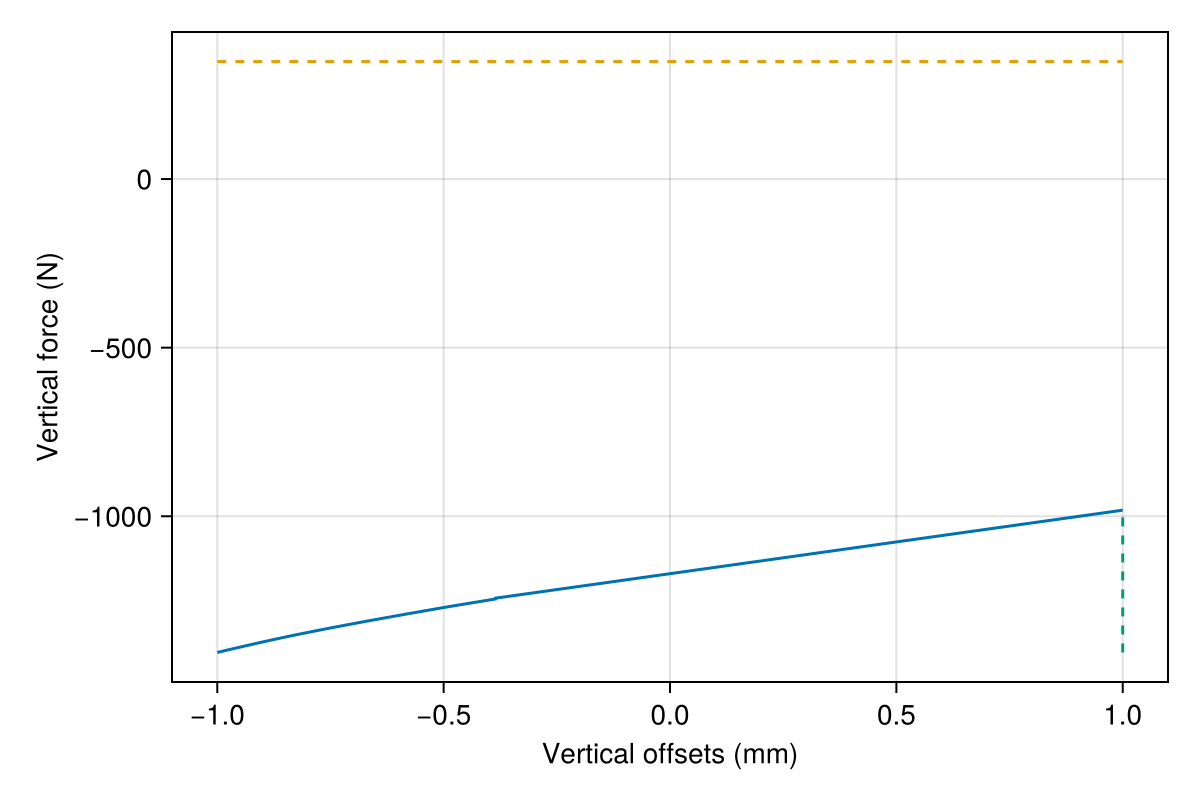

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /home/genisis/.julia/packages/Makie/ux0Te/src/scenes.jl:238


 __  __            _        _____       _ _ 
|  \/  |          | |      / ____|     (_) |
| \  / |_   _     | | ___ | |     ___   _| |
| |\/| | | | |_   | |/ _ \| |    / _ \ | | |
| |  | | |_| | |__| | (_) | |___| (_) || | |
|_|  |_|\__,_|\____/ \___/ \_____\___(_) |_|
                                      _/ |  
                                     |__/   

Press "F1" to show the help message.


In [ ]:

heights = LinRange(-0.001, 0.001, 2001)
u_vert = zeros(length(heights))
for k in eachindex(heights)

    # Set model in position and assume qacc == 0
    reset_state!(model, data, joint_angles)
    orient_left_foot_flat!(model, data)
    forward!(model, data)
    data.qacc .= 0

    # Offset the height and check required vertical forces
    data.qpos[3] += heights[k]
    mj_inverse(model, data)
    u_vert[k] = data.qfrc_inverse[3] # 3 -> z-force
end

height = heights[argmin(abs.(u_vert))]
weight = sum(model.body_mass) * norm(model.opt.gravity)

fig = Figure(resolution=(600,400))
ax = Axis(fig[1,1], xlabel="Vertical offsets (mm)", ylabel="Vertical force (N)")
lines!(ax, heights*1000, u_vert)
lines!(ax, heights*1000, weight*ones(length(heights)), linestyle=:dash)
lines!(ax, [height, height]*1000, [minimum(u_vert), maximum(u_vert)], linestyle=:dash)
isplot && display(fig)
isplot && visualise!(model, data)


We'll use the best-choice offset to get our required ID forces and save q0

In [ ]:
resetkey!(model, data, keyframe)
forward!(model, data)
data.qacc .= 0
data.qpos[3] += height
qpos0 = vec(copy(data.qpos))
mj_inverse(model, data)
qfrc0 = vec(copy(data.qfrc_inverse))
println("Desired forces qfrc0 acquired")

Need the corresponding control torque (through the actuators)

In [ ]:
M_act = data.actuator_moment
ctrl0 = pinv(M_act)' * qfrc0
println("Control set-point ctrl0 acquired")

Double-check (note: this works because the humanoid is fully-actuated!)

In [ ]:
data.ctrl .= ctrl0
forward!(model, data)
qfrc_test = vec(copy(data.qfrc_actuator))
println("Desired force meets actual? ", all((qfrc_test .≈ qfrc0)[7:end]))

Run the simulation


In [ ]:
reset!(model, data)
data.qpos .= qpos0
data.ctrl .= ctrl0

isplot && visualise!(model, data)

## LQR Design

In [ ]:
# Useful dimensions
nu = model.nu
nv = model.nv

# R-matrix just identity
R = Matrix{Float64}(I, nu, nu)

# Body IDs
torso = MJ.body(model, "torso")
left_foot = MJ.body(model, "foot_left")

# Get Jacobian for torso CoM
reset!(model, data)
data.qpos .= qpos0
forward!(model, data)
jac_com = mj_zeros(3, nv)
mj_jacSubtreeCom(model, data, jac_com, torso.id)

# Get (left) foot Jacobian for balancing
jac_foot = mj_zeros(3, nv)
mj_jacBodyCom(model, data, jac_foot, nothing, left_foot.id)

# Design Q-matrix to balance CoM over foot
jac_diff = jac_com .- jac_foot
Qbalance = jac_diff' * jac_diff

Now we include a cost on joints deviating from the steady-state. Torso already sorted. Left leg should remain rigid. Other joints can move for balance.


In [ ]:

# Get indices into relevant sets of joints.
free_dofs = 1:6
body_dofs = 7:nv

# Get all the joints using a list comprehension. We add one to the raw ID to get the Julia 1-based index of the joint.
abdomen_dofs = [jnt.id+1 for jnt in MJ.joints(model) if occursin("abdomen", jnt.name)]
left_leg_dofs = [jnt.id+1 for jnt in MJ.joints(model) if occursin("left", jnt.name) && any(occursin(part, jnt.name) for part in ("hip", "knee", "ankle"))]

balance_dofs = vcat(abdomen_dofs, left_leg_dofs)
other_dofs = setdiff(body_dofs, balance_dofs)

# Cost coefficients
balance_cost       = 1000       # CoM units large, keep it still
balance_joint_cost = 3          # Joints can move a bit and still balance
other_joint_cost   = 0.3        # Other joints can do whatever

# Construct joint Q matrix
Qjoint = Matrix{Float64}(I, nv, nv)
Qjoint[free_dofs, free_dofs] *= 0
Qjoint[balance_dofs, balance_dofs] *= balance_joint_cost
Qjoint[other_dofs, other_dofs] *= other_joint_cost

# Total Q-matrix
Qpos = balance_cost*Qbalance + Qjoint
Q = [Qpos zeros(nv,nv); zeros(nv, 2nv)]  + (1e-10)I # Add ϵI for positive definite Q

# Get A and B matrices from Jacobian
reset!(model, data)
data.ctrl .= ctrl0
data.qpos .= qpos0

A = mj_zeros(2nv, 2nv)
B = mj_zeros(2nv, nu)
ϵ = 1e-6
centred = true
mjd_transitionFD(model, data, ϵ, centred, A, B, nothing, nothing)

# Solve LQR with MatrixEquations.jl (faster than loading ControlSystems.jl)
S = zeros(size(Q,1), size(R,1))
_, _, K, _ = ared(A,B,R,Q,S)

# Write the LQR function
function humanoid_ctrl!(m::Model, d::Data)

    # Get difference in states qpos - qpos0 (this function does quaternion diff)
    Δq = zeros(nv)
    mj_differentiatePos(m, Δq, 1, qpos0, d.qpos)
    Δx = vcat(Δq, data.qvel)

    # Compute controls with LQR
    data.ctrl .= (ctrl0 .- K*Δx)
    return nothingattach_left_ankle!
end

# Initialise the humanoid and visualise
reset!(model, data)
data.qpos .= qpos0
visualise!(model, data, controller=humanoid_ctrl!)